1. Задание
    - Сформировать с помощью `sklearn.make_classification` датасет из 1000 объектов с **двумя** признаками.  
    - Обучить случайный лес из 1, 3, 10, 50, 100 и 200 деревьев.  
    - Визуализировать их разделяющие линии на графиках (по подобию визуализации деревьев из предыдущего урока).   
    - Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

2. Задание\* 
    - Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

**решение**

1) объединил 1-е и 2-е задания и в алгоритме дерева сразу собираю Out-of-Bag-выборку, далее в цикле формирую лес перебором параметров:

- ```depth``` - максимально допустимое количество уровней у дерева от 1-го до 5-ти
- ```n_trees``` - количестве деревьев в лесу - как по заданию 1, 3, 10, 50, 100 и 200 деревьев

2) далее на графиках показаны изменение метрики ```accuracy``` в зависимости от изменений ```depth``` и ```n_trees```

3) из всех получившихся 30-ти лесов выбираю те значения для OOB-выборки ```depth``` и ```n_trees```, при которых метрика ```accuracy``` вернула наилучший результат.

4) эти параметры применяю для формирования леса, но уже на разделённой на train и test выборке, и визуализирую разделяющие линии на графике

5) в конце пара слов - это выводы)

_____
_____

In [1]:
import matplotlib.pyplot as plt
import random
from matplotlib.colors import ListedColormap
from sklearn import datasets
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

сформируем датасет и посмотрим на него

In [2]:
X, y = make_classification(n_samples=1000,
                           n_features=2, n_informative=2, 
                           n_classes=2, n_redundant=0, 
                           n_clusters_per_class=2, flip_y=0.1, random_state=44)

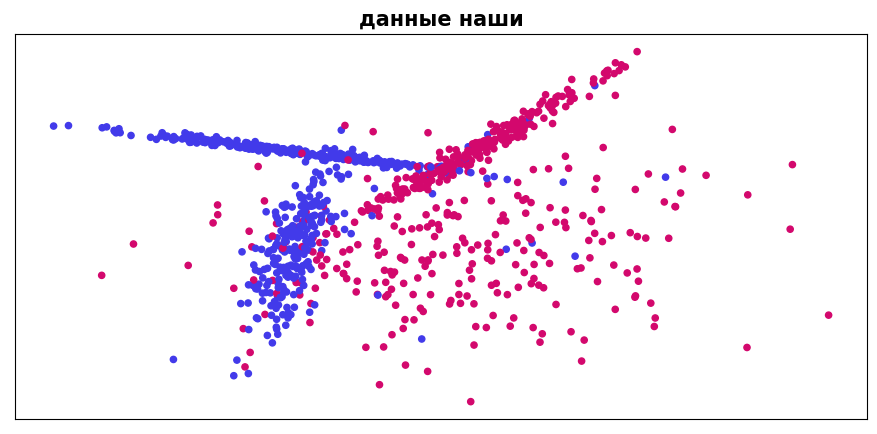

In [3]:
colors = ListedColormap(['#423AEA', '#D3086D'])
light_colors = ListedColormap(['#87ECF8', '#F5BBF3'])

plt.figure(figsize=(11,5))
plt.scatter(list(map(lambda _: _[0], X)), list(map(lambda _: _[1], X)), c=y, cmap=colors, s=20)
plt.title('данные наши', fontsize=15, fontweight='bold')
plt.xticks([])
plt.yticks([]);

ниже весь наш алгоритм с описанием функций, классов и кто из них что делает

In [4]:
random.seed(42)

def get_bootstrap(data, labels, N):
    '''
    функция формирует выборки
    :param data: датасет, labels: признаки, N: кол-во деревье в ансамбле
    :return bootstrap: кортеж с выборкой и OOB-признаки
    '''
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        s_set = set()
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
            s_set.add(sample_index)
            
        out_of_bag_data = np.delete(data, list(s_set), axis=0)
        out_of_bag_labels = np.delete(labels, list(s_set), axis=0)
        
        bootstrap.append((b_data, b_labels, out_of_bag_data, out_of_bag_labels))

    return bootstrap

In [5]:
def get_subsample(len_sample):
    '''
    функция реализует выбор индексов случайных признаков
    :param len_sample: общее количество признаков
    :return subsample: sqrt из перемешанных индексов len_sample
    '''
    sample_indexes = [i for i in range(len_sample)]
    len_subsample = int(np.sqrt(len_sample))
    random.shuffle(sample_indexes)
    subsample = [sample_indexes.pop() for _ in range(len_subsample)]
        
    return subsample

In [6]:
# класс узла
class Node:
    count = 0

    def __init__(self, index, t, true_branch, false_branch, level):
        self.index = index                 # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t                         # значение порога
        self.true_branch = true_branch     # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch   # поддерево, не удовлетворяющее условию в узле
        self.level = level
        Node.count += 1

In [7]:
# класс листа (терминального узла)
class Leaf:
    count = 0

    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        Leaf.count += 1

    def predict(self):
        '''возвращает класс, количество объектов которого максимально в конкретном'''
        classes = {}
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        prediction = max(classes, key=classes.get)
        return prediction

In [8]:
# класс-счётчик для ограничения количества узлов
class NodesCount:
    count = 0

    def __init__(self, max_nodes):
        self.max_nodes = max_nodes
        NodesCount.count += 1

    def max_node(self):
        if self.max_nodes == 0:
            self.max_nodes = 1e15
        if NodesCount.count-1 >= self.max_nodes:
            return 'stop'


# класс-счётчик для ограничения количества листов
class LeafsCount:
    count = 0

    def __init__(self, max_leafs):
        self.max_leafs = max_leafs
        LeafsCount.count += 1

    def max_leaf(self):
        if self.max_leafs == 0:
            self.max_leafs = 1e15
        if LeafsCount.count >= self.max_leafs:
            return 'stop'

In [9]:
def reset_counters():
    '''сбросить счёткики классов NodesCount и LeafsCount'''
    Node.count, Leaf.count, NodesCount.count, LeafsCount.count = 0, 0, 0, 0

In [10]:
def gini(labels):
    '''
    индекс Джини
    :return impurity: коэффициент неопределенности Джини
    '''
    classes, impurity = {}, 1
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
        
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [11]:
def quality(left_labels, right_labels, current_gini):
    '''
    Расчет качества Q
    :return Q: качество разбиения
    '''
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [12]:
def split(data, labels, index, t):
    '''
    Разбиение датасета в узле
    :return разбитые данные true_data, false_data, true_labels, false_labels
    '''
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data, false_data = data[left], data[right]
    true_labels, false_labels = labels[left], labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [13]:
def find_best_split(data, labels, min_leaf):
    '''
    Функция находит наилучшее разбиение
    :param data: данные, labels: признаки, min_leaf: минимальное кол-во объектов в узле
    :return best_quality, best_t, best_index
    '''
    current_gini = gini(labels)
    best_quality, best_t, best_index = 0, None, None
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее min_leaf объекта
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [14]:
def build_tree(data, labels, min_leaf, depth, count_nodes, count_leafs, level=0):
    '''
    Рекурсивное построение дерева
    :param data: данные, labels: признаки, min_leaf: минимальное кол-во объектов в узле
           depth: максимально допустимое количество уровней дерева, 
           count_nodes: максимально допустимое количество узлов 
           count_leafs: максимально допустимое количество узлов, level=0: счётчик
    :return Leaf or Node: экземпляр класса Leaf или Node
    '''

    quality, t, index = find_best_split(data, labels, min_leaf)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)
    
    # прекращаем рекурсию, когда достигнуто максимальное количество уровней
    try:
        if depth and level >= depth:
            return Leaf(data, labels=labels)
    except:
        pass

    # прекращаем рекурсию, когда достигнуто максимальное количество узлов
    step_nodes = NodesCount(count_nodes)
    if step_nodes.max_node() == 'stop':
        return Leaf(data, labels=labels)
    # прекращаем рекурсию, когда достигнуто максимальное количество листьев
    step_leafs = LeafsCount(count_leafs)
    if step_leafs.max_leaf() == 'stop':
        return Leaf(data, labels=labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    level += 1
    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, min_leaf, depth, count_nodes, count_leafs, level)
    false_branch = build_tree(false_data, false_labels, min_leaf, depth, count_nodes, count_leafs, level)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch, level)

In [15]:
def random_forest(data, labels, n_trees, min_leaf=1, depth=0, count_nodes=0, count_leafs=0):
    '''
    функция формирования случайного леса
    :param data: данные, labels: признаки, min_leaf: минимальное кол-во объектов в узле
           depth: максимально допустимое количество уровней дерева, 
           count_nodes: максимально допустимое количество узлов 
           count_leafs: максимально допустимое количество узлов
    :return forest: лес, accuracy: значение accuracy на OOB-признаках
    '''
    forest, accuracy_list = [], []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels, out_of_bag_data, out_of_bag_labels in bootstrap:
        tree = build_tree(b_data, b_labels, min_leaf, depth, count_nodes, count_leafs)
        forest.append(tree)
        reset_counters()
        
        # считаем accuracy для OOB-признаков каждого дерева
        accuracy_list.append(accuracy_metric(out_of_bag_labels, tree_vote([tree], out_of_bag_data)))
    accuracy = sum(accuracy_list)/len(accuracy_list)
    
    return forest, accuracy

In [16]:
def classify_object(obj, node):
    '''
    функция определения класса объекта
    :return answer: предсказание класса
    '''

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf): 
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [17]:
def predict(data, tree):
    '''
    функция формирования предсказания по выборке на одном дереве
    '''
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
        
    return classes

In [18]:
def tree_vote(forest, data):
    '''
    функция сформирует список с предсказаниями для каждого объекта
    возвращает предсказание голосованием деревьев и 
    возвращает в качестве итогового предсказания для каждого объекта то,
    за которое проголосовало большинство деревьев
    '''
    predictions = [predict(data, tree) for tree in forest]
    predictions_per_object = list(zip(*predictions))
    voted_predictions = [max(set(obj), key=obj.count) for obj in predictions_per_object]
       
    return voted_predictions

In [19]:
def accuracy_metric(actual, predicted):
    '''
    функция для подсчёта метрики accuracy
    :param actual: истинные значения, predicted: предсказанные значения
    :return accuracy
    '''
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [20]:
def show_forest_creation_in_a_diagram(train_data, test_data, train_labels, test_labels, colors, light_colors):
    '''отрисовка модели леса на диаграмме рассеивания + подсчёт accuracy для train и test'''
    
    train_answers = accuracy_metric(train_labels, tree_vote(best_forest, train_data))
    answers = accuracy_metric(test_labels, tree_vote(best_forest, test_data))

    # Визуализируем дерево на графике
    def get_meshgrid(data, step=0.05, border=1.2):
        x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
        y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
        return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


    #plt.figure(figsize = (16, 7))
    figure, axes = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(12, 5 * 1))

    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(best_forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

    plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c=test_labels, cmap=colors , s=15, alpha=0.85)
    plt.title(f'TEST, accuracy = {answers:.2f}')

    plt.subplot(1, 2, 1)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, cmap=colors, s=15, alpha=0.85)
    plt.title(f'TRAIN, accuracy = {train_answers:.2f}');

_____
_____

In [21]:
X.shape

(1000, 2)

In [22]:
y.shape

(1000,)

**поиграемся с параметрами depth (количество уровней от 1 до 5-ти) и n_trees (количество деревьев на каждый уровень по списку [1, 3, 10, 50, 100, 200], построим два графика, на которых отметим изменение accuracy для всех признаков и OOB-признаков при разных гиперпараметрах, а так же найдём лучшие значения для depth и n_trees**

МАКСИМАЛЬНО УРОВНЕЙ: 1, ДЕРЕВЬЕВ: 1, точность на всех признаках: 58.500, точность на OOB-признаках: 59.229
МАКСИМАЛЬНО УРОВНЕЙ: 1, ДЕРЕВЬЕВ: 2, точность на всех признаках: 95.500, точность на OOB-признаках: 87.062
МАКСИМАЛЬНО УРОВНЕЙ: 1, ДЕРЕВЬЕВ: 3, точность на всех признаках: 98.000, точность на OOB-признаках: 86.503
МАКСИМАЛЬНО УРОВНЕЙ: 1, ДЕРЕВЬЕВ: 4, точность на всех признаках: 97.500, точность на OOB-признаках: 86.310
МАКСИМАЛЬНО УРОВНЕЙ: 1, ДЕРЕВЬЕВ: 10, точность на всех признаках: 98.800, точность на OOB-признаках: 86.844
МАКСИМАЛЬНО УРОВНЕЙ: 1, ДЕРЕВЬЕВ: 50, точность на всех признаках: 99.900, точность на OOB-признаках: 85.701
МАКСИМАЛЬНО УРОВНЕЙ: 1, ДЕРЕВЬЕВ: 100, точность на всех признаках: 100.000, точность на OOB-признаках: 86.095
МАКСИМАЛЬНО УРОВНЕЙ: 1, ДЕРЕВЬЕВ: 200, точность на всех признаках: 100.000, точность на OOB-признаках: 86.072
МАКСИМАЛЬНО УРОВНЕЙ: 2, ДЕРЕВЬЕВ: 1, точность на всех признаках: 95.300, точность на OOB-признаках: 86.981
МАКСИМАЛЬНО УРОВНЕЙ: 2, ДЕРЕВ

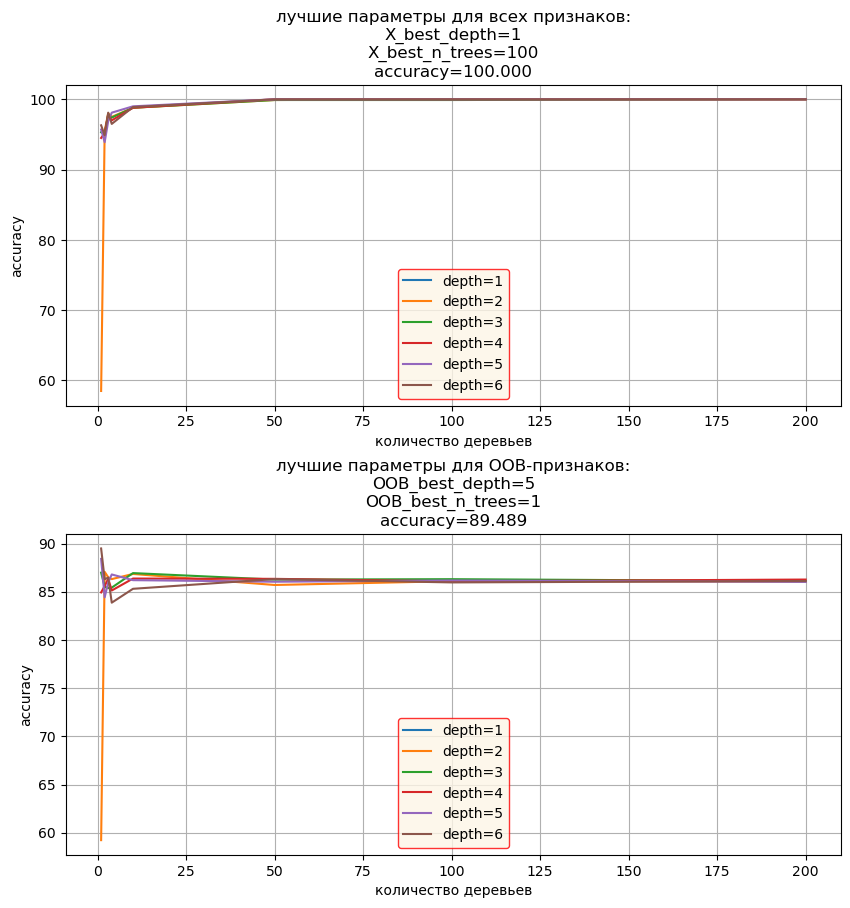

In [23]:
%%time
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
ax1, ax2 = ax.flatten()

X_best_depth, X_best_n_trees, OOB_best_depth, OOB_best_n_trees, X_accuracy_, OOB_accuracy_ = 0, 0, 0, 0, 0, 0
n_trees_list, X_accuracy_list, OOB_accuracy_list = [], [], []
n_trees=1

my_forest, OOB_accuracy = random_forest(X, y, n_trees, depth=1)
X_accuracy = accuracy_metric(y, tree_vote(my_forest, X))

n_trees_list.append(n_trees)
X_accuracy_list.append(X_accuracy)
OOB_accuracy_list.append(OOB_accuracy)

depth = 1
depth_enumerate = range(1, 7)
for step in depth_enumerate:
    
    ax1.plot(n_trees_list, X_accuracy_list, label=f'{depth=}')
    ax1.set_xlabel('количество деревьев')
    ax1.set_ylabel('accuracy')
    ax1.legend(facecolor='oldlace', edgecolor='r', loc='lower center')
    #ax1.set_yscale('log')
    ax2.plot(n_trees_list, OOB_accuracy_list, label=f'{depth=}')
    ax2.set_xlabel('количество деревьев')
    ax2.set_ylabel('accuracy')
    ax2.legend(facecolor='oldlace', edgecolor='r', loc='lower center')
    #ax2.set_yscale('log')
    
    n_trees, n_trees_list, X_accuracy_list, OOB_accuracy_list = 1, [], [], []
    
    for i in [2, 3, 4, 10, 50, 100, 200, 1]:
        if step == depth_enumerate[-1]:
            continue
            
        print(f'МАКСИМАЛЬНО УРОВНЕЙ: {depth}, ДЕРЕВЬЕВ: {n_trees}, '
              f'точность на всех признаках: {X_accuracy:.3f}, '
              f'точность на OOB-признаках: {OOB_accuracy:.3f}')

        if X_accuracy_ < X_accuracy:
            X_accuracy_, X_best_depth, X_best_n_trees = X_accuracy, depth, n_trees
        if OOB_accuracy_ < OOB_accuracy:
            OOB_accuracy_, OOB_best_depth, OOB_best_n_trees = OOB_accuracy, depth, n_trees

        n_trees_list.append(n_trees)
        X_accuracy_list.append(X_accuracy)
        OOB_accuracy_list.append(OOB_accuracy)
        n_trees = i

        my_forest, OOB_accuracy = random_forest(X, y, n_trees=n_trees, depth=_)
        X_accuracy = accuracy_metric(y, tree_vote(my_forest, X))
    depth += 1
    
ax1.set_title(f'лучшие параметры для всех признаков:\n{X_best_depth=}\n{X_best_n_trees=}\naccuracy={X_accuracy_:.3f}')
ax1.grid()
ax2.set_title(f'лучшие параметры для OOB-признаков:\n{OOB_best_depth=}\n{OOB_best_n_trees=}\naccuracy={OOB_accuracy_:.3f}')
ax2.grid()
fig.set_size_inches(10, 10) 
plt.subplots_adjust(hspace=0.4);

**вот теперь на лучших найденных гиперпараметрах ```OOB_best_n_trees``` и ```OOB_best_depth``` построим алгоритм, обучим, предскажем, отрисуем разделяющие линии**

**но на этот раз порежем данные через train_test_split на 70:30 и посмотрим, какое значение accuracy получится при таком подходе**

In [24]:
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size = 0.3, random_state = 47)
best_forest, OOB_accuracy = random_forest(X, y, n_trees=OOB_best_n_trees, depth=OOB_best_depth)

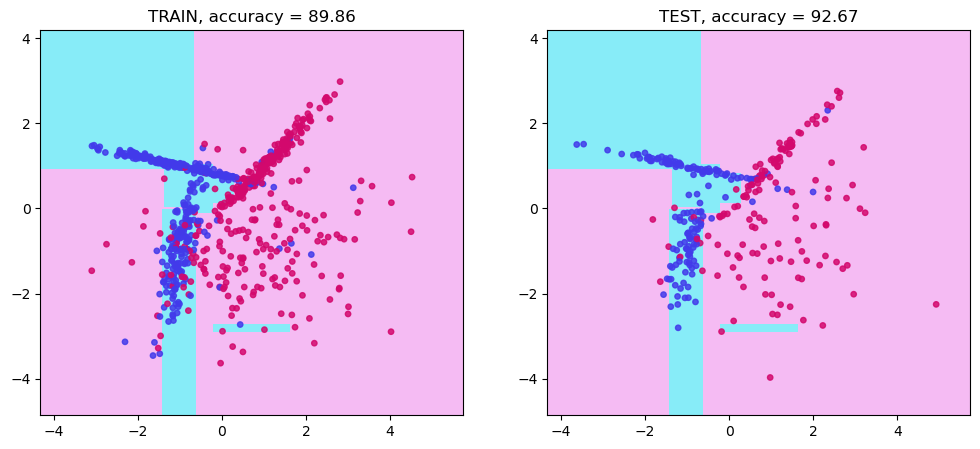

In [25]:
show_forest_creation_in_a_diagram(train_data, test_data, train_labels, test_labels, colors, light_colors)

**Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.**

значение accuracy на OOB-выборке немного ниже, чем на 30% test-выборки, при этом видно, что accuracy на OOB-выборке даже при относительно малом количестве деревьев в лесу достаточно быстро выходит на асимптоту и держится приблизительно на одном уровне, в нашем примере это 85-86%

получается, что переобучить лес практически невозможно, алгоритм учится быстро и быстро приходит к хорошим предсказаниям, да так на них и остаётся, держит марку.